In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import plotly.express as px
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
# Cài đặt gdown nếu chưa cài
!pip install gdown

# Import các thư viện cần thiết
import gdown
import pandas as pd


url = 'https://drive.google.com/uc?id=130M61C_yngYZ6h40ofWuzk-zzr3kKR7J'

# Tải file về
gdown.download(url, 'student_depression_dataset.csv', quiet=False)

# Đọc dữ liệu CSV vào DataFrame
data = pd.read_csv("student_depression_dataset.csv", on_bad_lines='skip')
print(data.head(40))


Downloading...
From: https://drive.google.com/uc?id=130M61C_yngYZ6h40ofWuzk-zzr3kKR7J
To: /content/student_depression_dataset.csv
100%|██████████| 2.90M/2.90M [00:00<00:00, 124MB/s]


     id  Gender   Age           City Profession  Academic Pressure  \
0     2    Male  33.0  Visakhapatnam    Student                5.0   
1     8  Female  24.0      Bangalore    Student                2.0   
2    26    Male  31.0       Srinagar    Student                3.0   
3    30  Female  28.0       Varanasi    Student                3.0   
4    32  Female  25.0         Jaipur    Student                4.0   
5    33    Male  29.0           Pune    Student                2.0   
6    52    Male  30.0          Thane    Student                3.0   
7    56  Female  30.0        Chennai    Student                2.0   
8    59    Male  28.0         Nagpur    Student                3.0   
9    62    Male  31.0         Nashik    Student                2.0   
10   83    Male  24.0         Nagpur    Student                3.0   
11   91    Male  33.0       Vadodara    Student                3.0   
12   94    Male  27.0         Kalyan    Student                5.0   
13  100  Female  19.

Depression
1    16336
0    11565
Name: count, dtype: int64


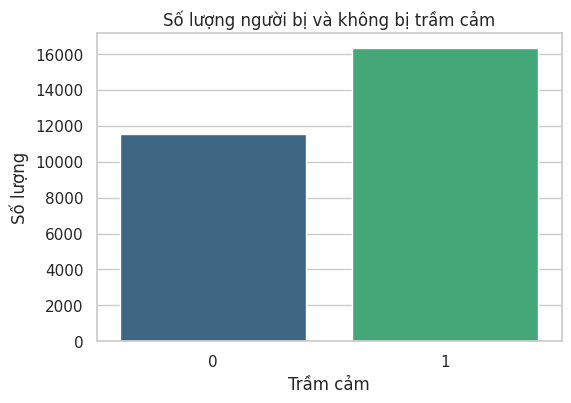

In [ ]:
depression_counts = data['Depression'].value_counts()
print(depression_counts)

# Vẽ biểu đồ histogram (cột) cho Depression
plt.figure(figsize=(6, 4))
sns.barplot(x=depression_counts.index, y=depression_counts.values, palette='viridis')
plt.title("Số lượng người bị và không bị trầm cảm")
plt.xlabel("Trầm cảm")
plt.ylabel("Số lượng")
plt.show()


In [ ]:
data.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

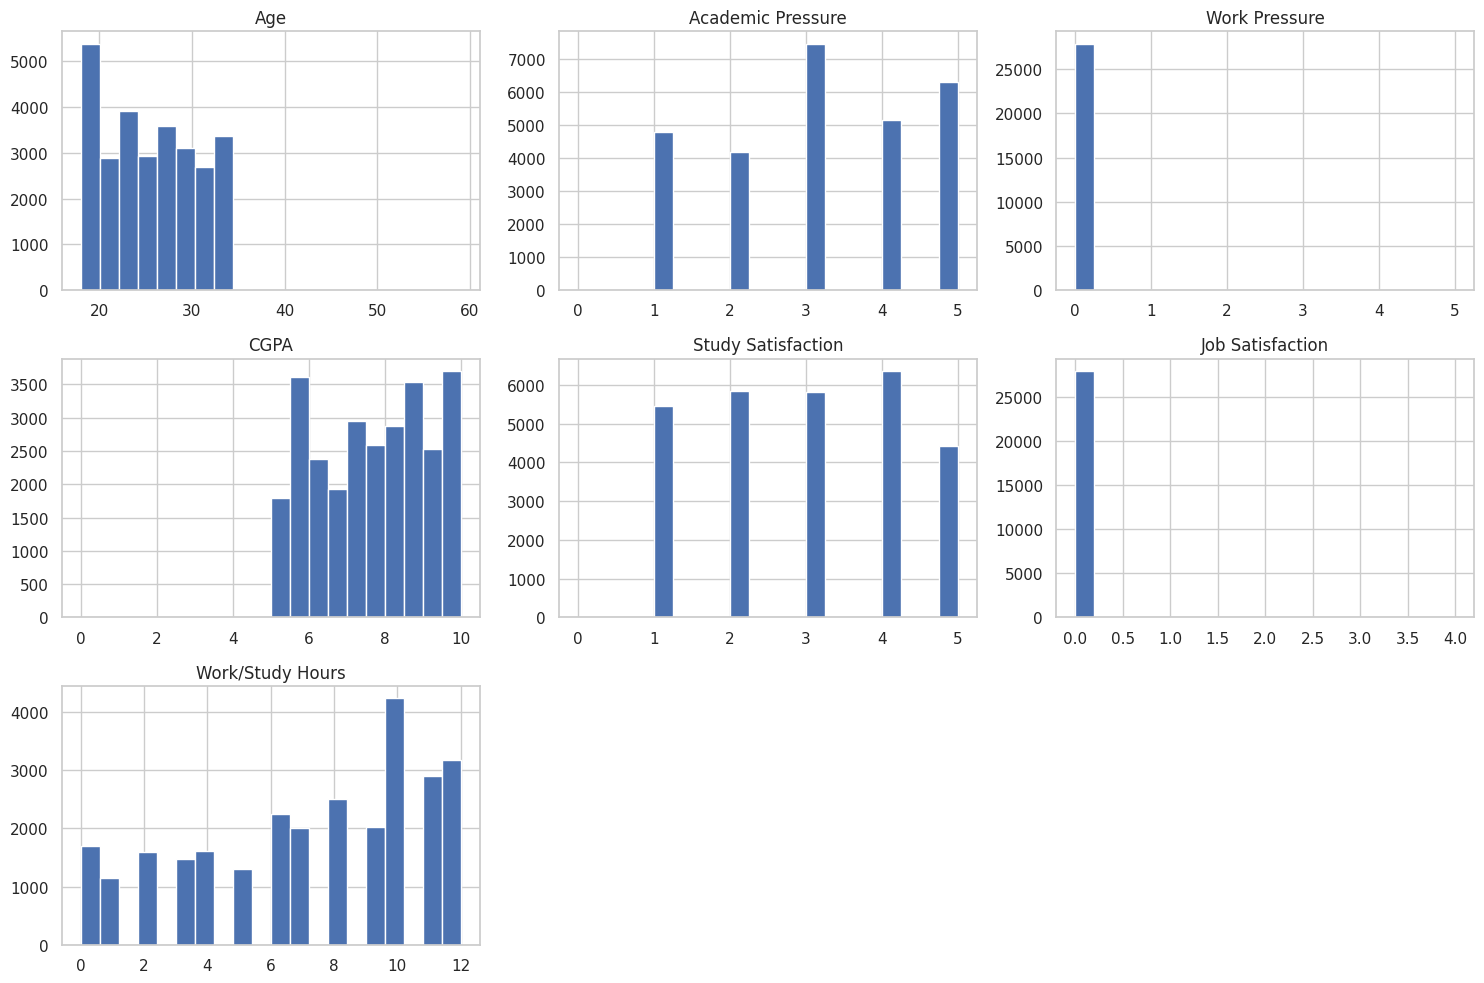

In [ ]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
data[num_features].hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()


In [ ]:
# Kiểm tra mối quan hệ giữa Work Pressure và Depression
print("Kiểm tra giữa Work Pressure và Depression:")
correlation_wp, p_value_wp = stats.spearmanr(data['Work Pressure'], data['Depression'])
print(f"Hệ số tương quan Spearman: {correlation_wp}")
print(f"p-value: {p_value_wp}")

if p_value_wp < 0.05:
    print("Cột Work Pressure và Depression có ý nghĩa thống kê.")
else:
    print("Cột Work Pressure và Depression không có ý nghĩa thống kê.")

Kiểm tra giữa Work Pressure và Depression:
Hệ số tương quan Spearman: -0.005307782154932299
p-value: 0.37531754953603147
Cột Work Pressure và Depression không có ý nghĩa thống kê.


In [ ]:
# Kiểm tra mối quan hệ giữa Work Pressure và Depression
print("Kiểm tra giữa Work Job Satisfaction và Depression:")
correlation_wp, p_value_wp = stats.spearmanr(data['Job Satisfaction'], data['Depression'])
print(f"Hệ số tương quan Spearman: {correlation_wp}")
print(f"p-value: {p_value_wp}")

if p_value_wp < 0.05:
    print("Cột Work Job Satisfaction và Depression có ý nghĩa thống kê.")
else:
    print("Cột Work Job Satisfaction và Depression không có ý nghĩa thống kê.")

Kiểm tra giữa Work Job Satisfaction và Depression:
Hệ số tương quan Spearman: -0.0029395213998137113
p-value: 0.6234372431535976
Cột Work Job Satisfaction và Depression không có ý nghĩa thống kê.


In [ ]:
# Xóa trực tiếp 2 cột cụ thể
data = data.drop(columns=['Work Pressure', 'Job Satisfaction'], errors='ignore')

num_features = ['Age', 'Academic Pressure','CGPA',
                'Study Satisfaction', 'Work/Study Hours']


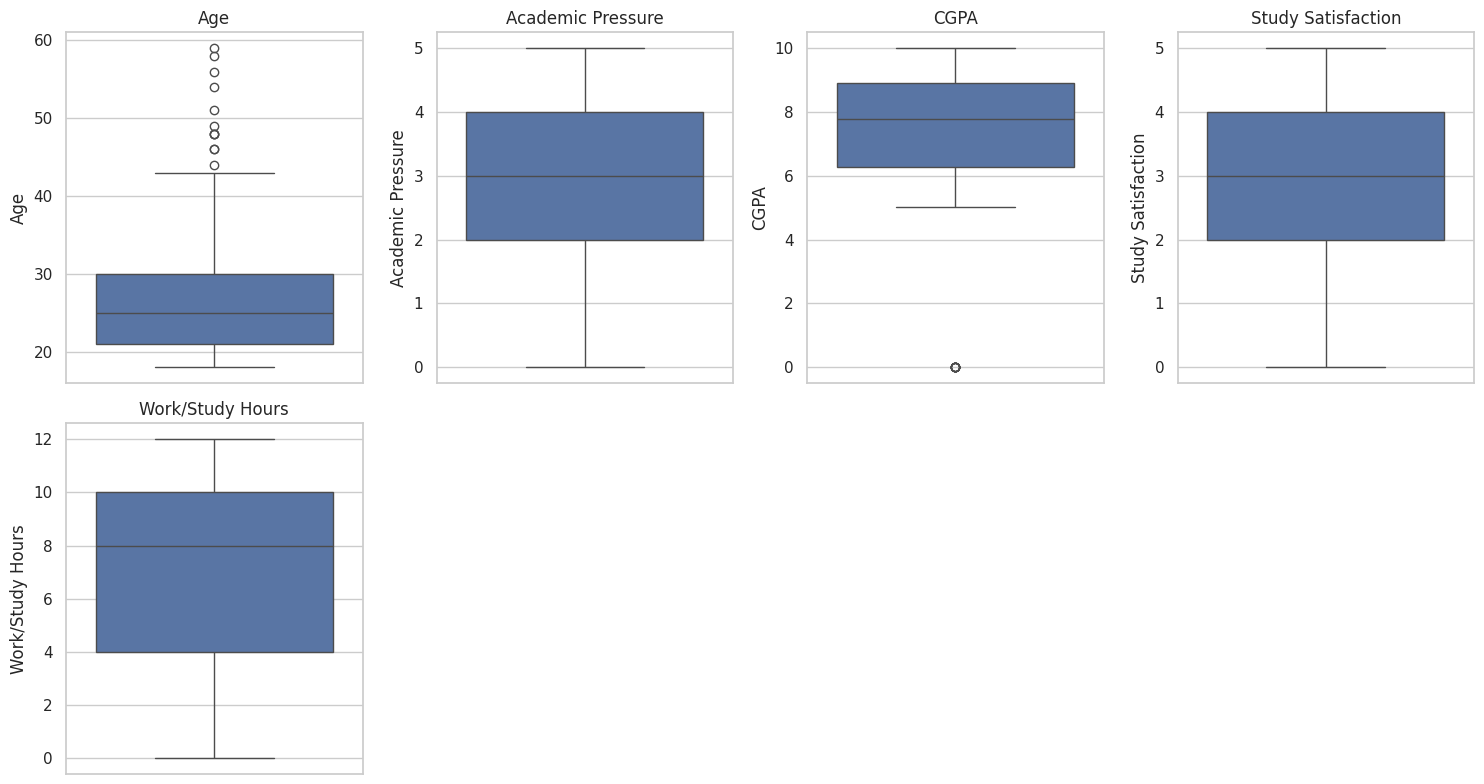

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(15, 8))

# Duyệt qua từng cột và vẽ boxplot
for i, feature in enumerate(num_features):
    plt.subplot(2, 4, i + 1)  # tạo lưới 2 hàng 4 cột
    sns.boxplot(y=data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Hàm loại bỏ outliers dựa trên IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # In số lượng outliers bị loại
    num_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    print(f"Số lượng outliers bị loại khỏi cột '{column}': {num_outliers}")

    # Loại bỏ các hàng chứa outliers
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Áp dụng cho Age và CGPA
data = remove_outliers_iqr(data, 'Age')
data = remove_outliers_iqr(data, 'CGPA')

Số lượng outliers bị loại khỏi cột 'Age': 12
Số lượng outliers bị loại khỏi cột 'CGPA': 9


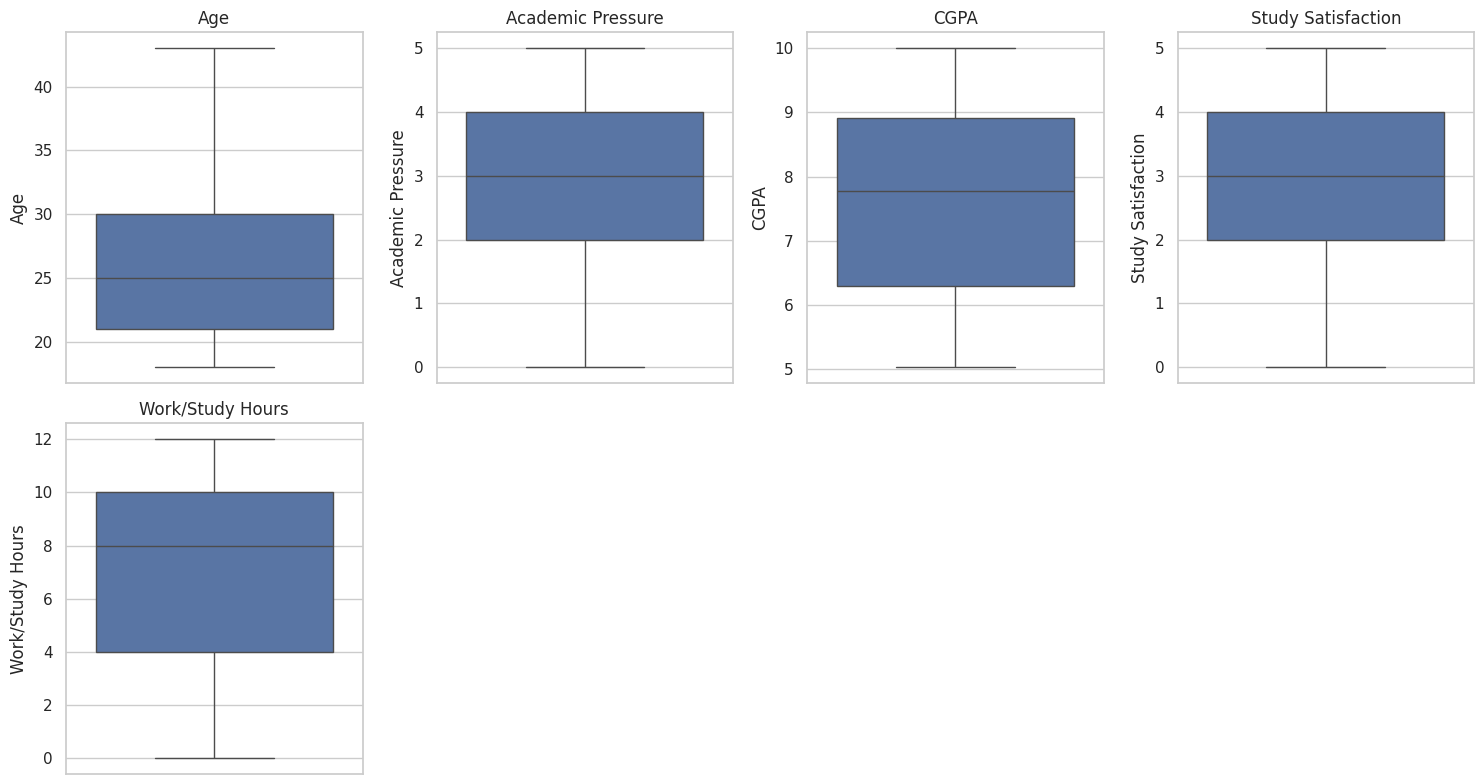

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Thiết lập kích thước của biểu đồ
plt.figure(figsize=(15, 8))

# Duyệt qua từng cột và vẽ boxplot
for i, feature in enumerate(num_features):
    plt.subplot(2, 4, i + 1)  # tạo lưới 2 hàng 4 cột
    sns.boxplot(y=data[feature])
    plt.title(feature)

plt.tight_layout()
plt.show()

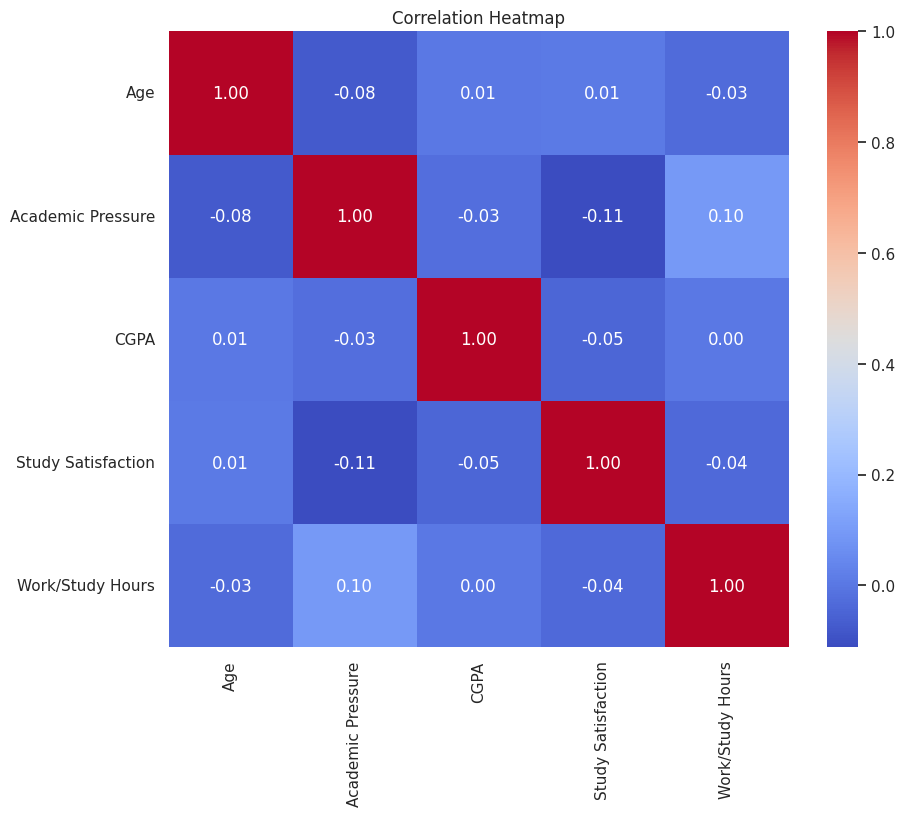

In [ ]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure',  'CGPA',
            'Study Satisfaction', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
#categories
import pandas as pd

# Tăng giới hạn hiển thị chiều ngang
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# In ra mô tả của các cột object
print(data.select_dtypes(include='object').describe())


       Gender    City Profession       Sleep Duration Dietary Habits      Degree Have you ever had suicidal thoughts ? Financial Stress Family History of Mental Illness
count   27880   27880      27880                27880          27880       27880                                 27880            27880                            27880
unique      2      52         14                    5              4          28                                     2                6                                2
top      Male  Kalyan    Student  'Less than 5 hours'      Unhealthy  'Class 12'                                   Yes              5.0                               No
freq    15537    1570      27849                 8303          10308        6070                                 17645             6709                            14387


In [ ]:
#Gender
print("Các giá trị duy nhất trong Gender:")
print(data['Gender'].unique())

print("\nTần suất từng giá trị:")
print(data['Gender'].value_counts())



Các giá trị duy nhất trong Gender:
['Male' 'Female']

Tần suất từng giá trị:
Gender
Male      15537
Female    12343
Name: count, dtype: int64


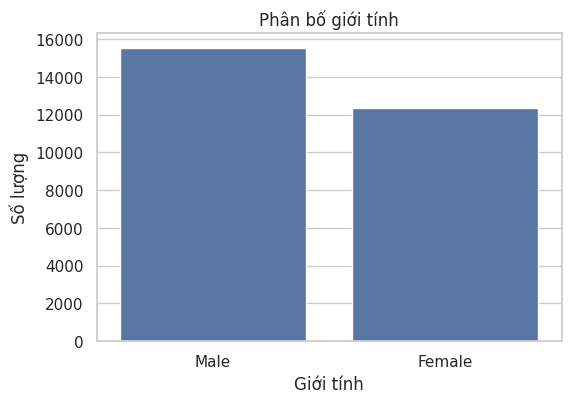

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='Gender')
plt.title("Phân bố giới tính")
plt.xlabel("Giới tính")
plt.ylabel("Số lượng")
plt.show()

Gender
Female    0.584704
Male      0.586535
Name: Depression, dtype: float64


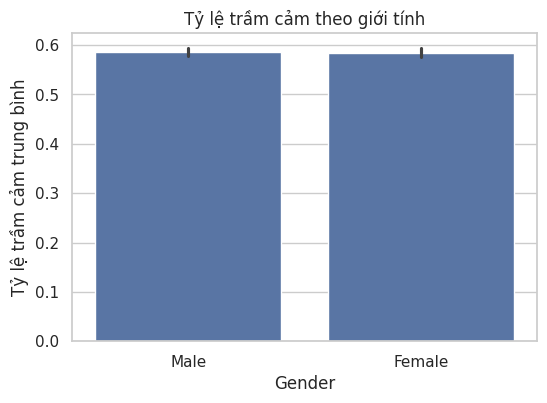

In [ ]:
# Tính trung bình (tỷ lệ trầm cảm) theo giới
print(data.groupby('Gender')['Depression'].mean())

# Trực quan hóa
plt.figure(figsize=(6,4))
sns.barplot(data=data, x='Gender', y='Depression')
plt.title("Tỷ lệ trầm cảm theo giới tính")
plt.ylabel("Tỷ lệ trầm cảm trung bình")
plt.show()

In [ ]:
#encoding
data['Gender'] = data['Gender'].map({
    'Male': 1,

    'Female': 2

})

In [ ]:
#City

# In top các giá trị phổ biến nhất
print(data['City'].value_counts())


City
Kalyan                  1570
Srinagar                1371
Hyderabad               1340
Vasai-Virar             1290
Lucknow                 1153
Thane                   1139
Ludhiana                1110
Agra                    1093
Surat                   1077
Kolkata                 1066
Jaipur                  1036
Patna                   1007
Visakhapatnam            969
Pune                     967
Ahmedabad                949
Bhopal                   933
Chennai                  883
Meerut                   824
Rajkot                   814
Delhi                    768
Bangalore                767
Ghaziabad                744
Mumbai                   699
Vadodara                 692
Varanasi                 685
Nagpur                   650
Indore                   643
Kanpur                   609
Nashik                   545
Faridabad                461
Saanvi                     2
Bhavna                     2
City                       2
Harsha                     2
'Less Del

In [ ]:
city_counts = data['City'].value_counts()
rare_cities = city_counts[city_counts < 100].index

# Gộp các thành phố hiếm lại thành "Others"
data['City'] = data['City'].apply(lambda x: 'Others' if x in rare_cities else x)

In [ ]:
print(data['City'].value_counts())

City
Kalyan           1570
Srinagar         1371
Hyderabad        1340
Vasai-Virar      1290
Lucknow          1153
Thane            1139
Ludhiana         1110
Agra             1093
Surat            1077
Kolkata          1066
Jaipur           1036
Patna            1007
Visakhapatnam     969
Pune              967
Ahmedabad         949
Bhopal            933
Chennai           883
Meerut            824
Rajkot            814
Delhi             768
Bangalore         767
Ghaziabad         744
Mumbai            699
Vadodara          692
Varanasi          685
Nagpur            650
Indore            643
Kanpur            609
Nashik            545
Faridabad         461
Others             26
Name: count, dtype: int64


In [ ]:
city_counts = data['City'].value_counts()
city_order = city_counts.sort_values().index
city_mapping = {city: idx + 1 for idx, city in enumerate(city_order)}

data['City'] = data['City'].map(city_mapping)

for city, label in city_mapping.items():
    print(f"{label}: {city}")



1: Others
2: Faridabad
3: Nashik
4: Kanpur
5: Indore
6: Nagpur
7: Varanasi
8: Vadodara
9: Mumbai
10: Ghaziabad
11: Bangalore
12: Delhi
13: Rajkot
14: Meerut
15: Chennai
16: Bhopal
17: Ahmedabad
18: Pune
19: Visakhapatnam
20: Patna
21: Jaipur
22: Kolkata
23: Surat
24: Agra
25: Ludhiana
26: Thane
27: Lucknow
28: Vasai-Virar
29: Hyderabad
30: Srinagar
31: Kalyan


In [ ]:
print(data['City'].value_counts())

City
31    1570
30    1371
29    1340
28    1290
27    1153
26    1139
25    1110
24    1093
23    1077
22    1066
21    1036
20    1007
19     969
18     967
17     949
16     933
15     883
14     824
13     814
12     768
11     767
10     744
9      699
8      692
7      685
6      650
5      643
4      609
3      545
2      461
1       26
Name: count, dtype: int64


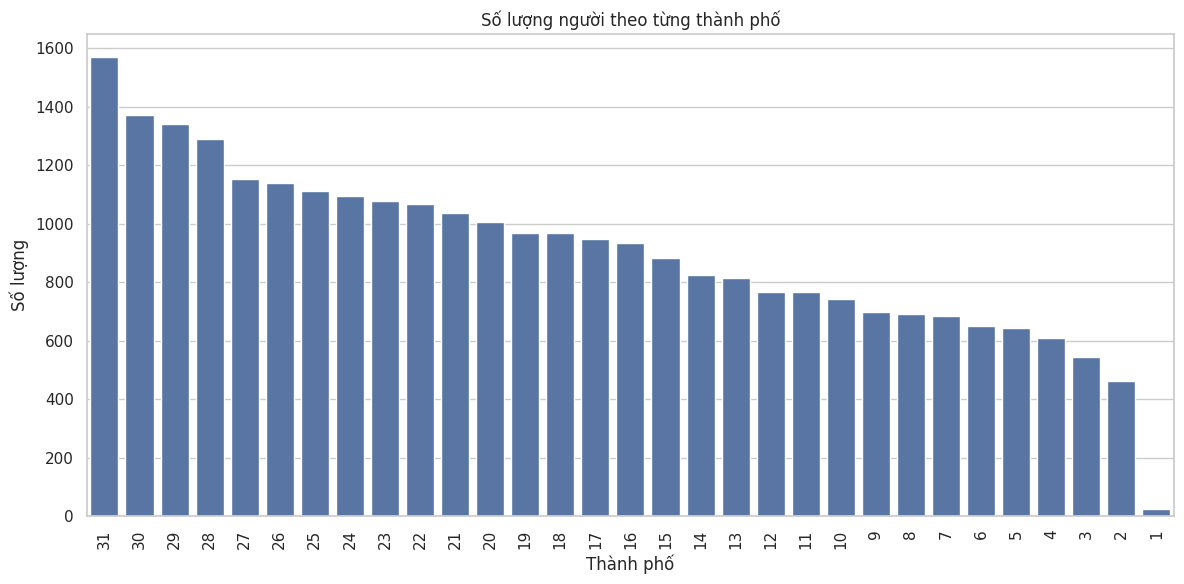

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=data, x='City', order=data['City'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Số lượng người theo từng thành phố")
plt.xlabel("Thành phố")
plt.ylabel("Số lượng")
plt.tight_layout()
plt.show()

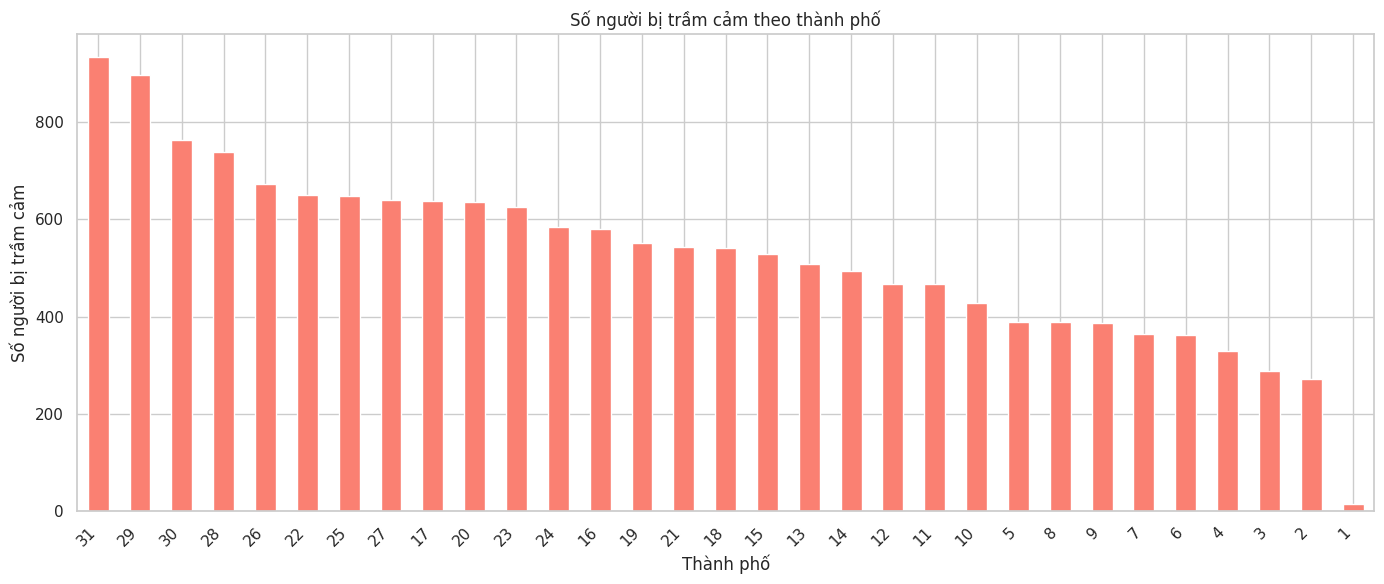

In [ ]:
# Group by City và tính tổng số người bị trầm cảm (Depression = 1)
depression_by_city = data.groupby('City')['Depression'].sum().sort_values(ascending=False)
plt.figure(figsize=(14, 6))
depression_by_city.plot(kind='bar', color='salmon')
plt.title('Số người bị trầm cảm theo thành phố')
plt.xlabel('Thành phố')
plt.ylabel('Số người bị trầm cảm')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:



profession_counts = data['Profession'].value_counts()
print(profession_counts)


Profession
Student                     27849
Architect                       8
Teacher                         6
'Digital Marketer'              3
Chef                            2
'Content Writer'                2
Pharmacist                      2
Doctor                          2
'UX/UI Designer'                1
'Civil Engineer'                1
Manager                         1
'Educational Consultant'        1
Lawyer                          1
Entrepreneur                    1
Name: count, dtype: int64


In [ ]:
rare_profs = profession_counts[profession_counts < 100].index
data['Profession'] = data['Profession'].apply(lambda x: 'Others' if x in rare_profs else x)



In [ ]:
profession_counts = data['Profession'].value_counts()
print(profession_counts)

Profession
Student    27849
Others        31
Name: count, dtype: int64


In [ ]:
data['Profession'] = data['Profession'].str.replace("'", "").str.strip()
sleep_duration_map = {
    "Student": 1,
    "Others": 2

}

data['Profession'] = data['Profession'].map(sleep_duration_map)
print(data['Profession'].value_counts())

Profession
1    27849
2       31
Name: count, dtype: int64


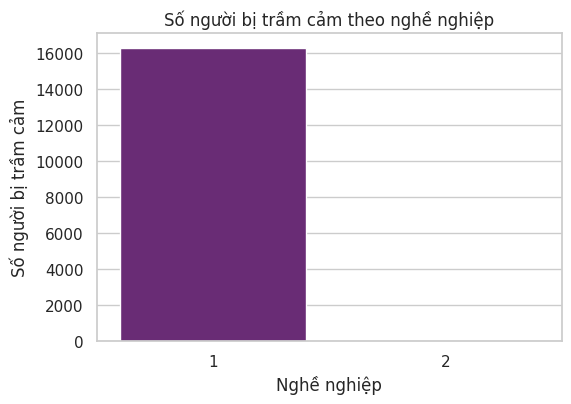

In [ ]:
depression_counts = data[data['Depression'] == 1]['Profession'].value_counts()
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
sns.barplot(x=depression_counts.index, y=depression_counts.values, palette='magma')
plt.title('Số người bị trầm cảm theo nghề nghiệp')
plt.xlabel('Nghề nghiệp')
plt.ylabel('Số người bị trầm cảm')
plt.show()


In [ ]:
#Sleep Duration

In [ ]:
sleep_counts = data['Sleep Duration'].value_counts()
print(sleep_counts)

Sleep Duration
'Less than 5 hours'    8303
'7-8 hours'            7340
'5-6 hours'            6178
'More than 8 hours'    6041
Others                   18
Name: count, dtype: int64


In [ ]:
data['Sleep Duration'] = data['Sleep Duration'].str.replace("'", "").str.strip()
sleep_duration_map = {
    "Less than 5 hours": 1,
    "5-6 hours": 2,
    "7-8 hours": 3,
    "More than 8 hours": 4,
    "Others": 5  # có thể dùng np.nan nếu bạn muốn coi như missing value
}

data['Sleep Duration'] = data['Sleep Duration'].map(sleep_duration_map)
print(data['Sleep Duration'].value_counts())


Sleep Duration
1    8303
3    7340
2    6178
4    6041
5      18
Name: count, dtype: int64


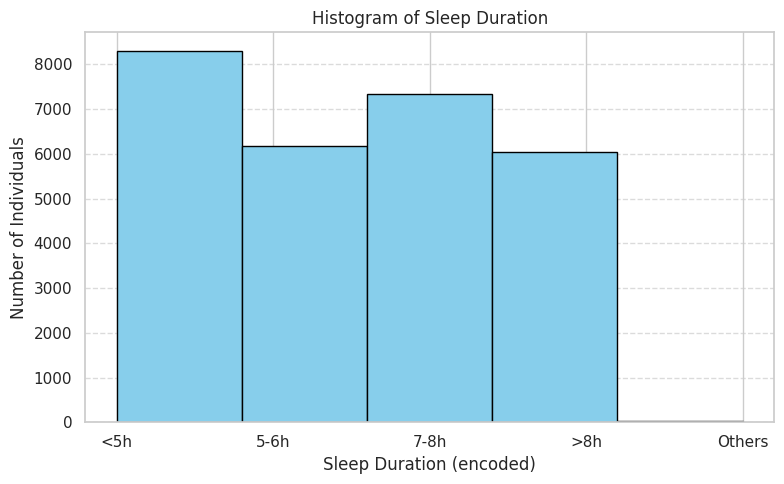

In [ ]:
# Vẽ biểu đồ histogram
plt.figure(figsize=(8, 5))
plt.hist(data['Sleep Duration'].dropna(), bins=5, edgecolor='black', color='skyblue')

plt.title('Histogram of Sleep Duration')
plt.xlabel('Sleep Duration (encoded)')
plt.ylabel('Number of Individuals')
plt.xticks([5, 1, 2, 3, 4], ['Others', '<5h', '5-6h', '7-8h', '>8h'])  # ghi rõ từng mức mã hóa
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

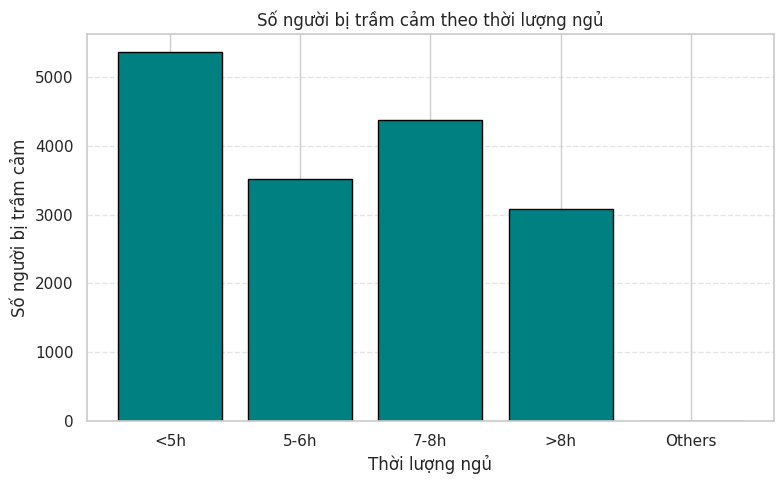

In [ ]:
depression_by_sleep = data.groupby('Sleep Duration')['Depression'].sum().sort_index()

# Nhãn tương ứng với mã hóa
sleep_labels = {
    1: '<5h',
    2: '5-6h',
    3: '7-8h',
    4: '>8h',
    5: 'Others'
}

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(
    [sleep_labels[i] for i in depression_by_sleep.index],  # labels đẹp
    depression_by_sleep.values,
    color='teal',
    edgecolor='black'
)

plt.title('Số người bị trầm cảm theo thời lượng ngủ')
plt.xlabel('Thời lượng ngủ')
plt.ylabel('Số người bị trầm cảm')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
habits_counts = data['Dietary Habits'].value_counts()
print(habits_counts)

Dietary Habits
Unhealthy    10308
Moderate      9914
Healthy       7646
Others          12
Name: count, dtype: int64


In [ ]:
data['Dietary Habits'] = data['Dietary Habits'].str.replace("'", "").str.strip()
sleep_duration_map = {
    "Unhealthy": 1,
    "Moderate": 2,
    "Healthy": 3,
    "Others": 4

}
data['Dietary Habits'] = data['Dietary Habits'].map(sleep_duration_map)
print(data['Dietary Habits'].value_counts())

Dietary Habits
1    10308
2     9914
3     7646
4       12
Name: count, dtype: int64


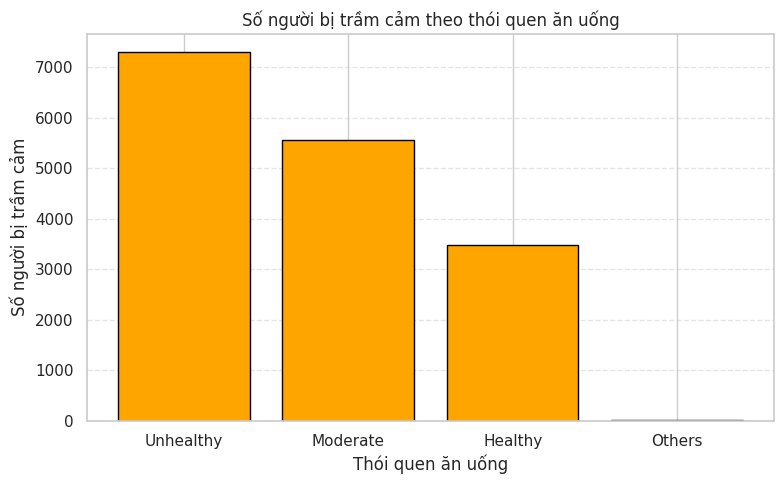

In [ ]:
# Nhóm và tính tổng người bị trầm cảm theo chế độ ăn uống
depression_by_diet = data.groupby('Dietary Habits')['Depression'].sum().sort_index()

# Nhãn đẹp cho biểu đồ
diet_labels = {
    1: 'Unhealthy',
    2: 'Moderate',
    3: 'Healthy',
    4: 'Others'
}

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.bar(
    [diet_labels[i] for i in depression_by_diet.index],  # tên nhãn
    depression_by_diet.values,
    color='orange',
    edgecolor='black'
)

plt.title('Số người bị trầm cảm theo thói quen ăn uống')
plt.xlabel('Thói quen ăn uống')
plt.ylabel('Số người bị trầm cảm')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
#Degree

habits_counts = data['Degree'].value_counts()
print(habits_counts)

Degree
'Class 12'    6070
B.Ed          1866
B.Com         1506
B.Arch        1478
BCA           1433
MSc           1190
B.Tech        1152
MCA           1043
M.Tech        1022
BHM            925
BSc            886
M.Ed           820
B.Pharm        810
M.Com          734
BBA            695
MBBS           695
LLB            670
BE             613
BA             600
M.Pharm        582
MD             571
MBA            562
MA             544
PhD            520
LLM            482
MHM            191
ME             185
Others          35
Name: count, dtype: int64


In [ ]:
# Làm sạch dữ liệu trước khi encode
data['Degree'] = data['Degree'].str.replace("'", "").str.strip()

# Sắp xếp và tạo ánh xạ
sorted_degrees = sorted(data['Degree'].unique())
degree_map = {degree: idx + 1 for idx, degree in enumerate(sorted_degrees)}

# In bảng ánh xạ
for degree, code in degree_map.items():
    print(f"{code}: {degree}")

# Áp dụng mã hóa lên cột Degree
data['Degree'] = data['Degree'].map(degree_map)

1: B.Arch
2: B.Com
3: B.Ed
4: B.Pharm
5: B.Tech
6: BA
7: BBA
8: BCA
9: BE
10: BHM
11: BSc
12: Class 12
13: LLB
14: LLM
15: M.Com
16: M.Ed
17: M.Pharm
18: M.Tech
19: MA
20: MBA
21: MBBS
22: MCA
23: MD
24: ME
25: MHM
26: MSc
27: Others
28: PhD


In [ ]:

habits_counts = data['Degree'].value_counts()
print(habits_counts)


Degree
12    6070
3     1866
2     1506
1     1478
8     1433
26    1190
5     1152
22    1043
18    1022
10     925
11     886
16     820
4      810
15     734
7      695
21     695
13     670
9      613
6      600
17     582
23     571
20     562
19     544
28     520
14     482
25     191
24     185
27      35
Name: count, dtype: int64


In [ ]:
#Have you... ?
have_counts = data['Have you ever had suicidal thoughts ?'].value_counts()
print(have_counts)


Have you ever had suicidal thoughts ?
Yes    17645
No     10235
Name: count, dtype: int64


In [ ]:
data['Have you ever had suicidal thoughts ?'] = data['Have you ever had suicidal thoughts ?'].str.replace("'", "").str.strip()
sleep_duration_map = {
    "Yes": 1,
    "No": 2,


}
data['Have you ever had suicidal thoughts ?'] = data['Have you ever had suicidal thoughts ?'].map(sleep_duration_map)
print(data['Have you ever had suicidal thoughts ?'].value_counts())

Have you ever had suicidal thoughts ?
1    17645
2    10235
Name: count, dtype: int64


In [ ]:
family_counts = data['Family History of Mental Illness'].value_counts()
print(family_counts)

Family History of Mental Illness
No     14387
Yes    13493
Name: count, dtype: int64


In [ ]:
data['Family History of Mental Illness'] = data['Family History of Mental Illness'].str.replace("'", "").str.strip()
sleep_duration_map = {
    "Yes": 1,
    "No": 2,


}
data['Family History of Mental Illness'] = data['Family History of Mental Illness'].map(sleep_duration_map)
print(data['Family History of Mental Illness'].value_counts())

Family History of Mental Illness
2    14387
1    13493
Name: count, dtype: int64


In [ ]:

financial_counts = data['Financial Stress'].value_counts()
print(financial_counts)



Financial Stress
5.0    6709
4.0    5769
3.0    5220
1.0    5120
2.0    5059
?         3
Name: count, dtype: int64


In [ ]:
data = data[data['Financial Stress'] != '?']

data['Financial Stress'] = data['Financial Stress'].astype(float).astype(int)

In [ ]:

financial_counts = data['Financial Stress'].value_counts()
print(financial_counts)

Financial Stress
5    6709
4    5769
3    5220
1    5120
2    5059
Name: count, dtype: int64


In [ ]:
data.head()


,id,Gender,Age,City,Profession,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,1,33.0,19,1,5.0,8.97,2.0,2,3,4,1,3.0,1,2,1
1,8,2,24.0,11,1,2.0,5.90,5.0,2,2,11,2,3.0,2,1,0
2,26,1,31.0,30,1,3.0,7.03,5.0,1,3,6,2,9.0,1,1,0
3,30,2,28.0,7,1,3.0,5.59,2.0,3,2,8,1,4.0,5,1,1
4,32,2,25.0,21,1,4.0,8.13,3.0,2,2,18,1,1.0,1,2,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27877 entries, 0 to 27900
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27877 non-null  int64  
 1   Gender                                 27877 non-null  int64  
 2   Age                                    27877 non-null  float64
 3   City                                   27877 non-null  int64  
 4   Profession                             27877 non-null  int64  
 5   Academic Pressure                      27877 non-null  float64
 6   CGPA                                   27877 non-null  float64
 7   Study Satisfaction                     27877 non-null  float64
 8   Sleep Duration                         27877 non-null  int64  
 9   Dietary Habits                         27877 non-null  int64  
 10  Degree                                 27877 non-null  int64  
 11  Have yo

In [ ]:
data.drop(columns=['id'], inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27877 entries, 0 to 27900
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 27877 non-null  int64  
 1   Age                                    27877 non-null  float64
 2   City                                   27877 non-null  int64  
 3   Profession                             27877 non-null  int64  
 4   Academic Pressure                      27877 non-null  float64
 5   CGPA                                   27877 non-null  float64
 6   Study Satisfaction                     27877 non-null  float64
 7   Sleep Duration                         27877 non-null  int64  
 8   Dietary Habits                         27877 non-null  int64  
 9   Degree                                 27877 non-null  int64  
 10  Have you ever had suicidal thoughts ?  27877 non-null  int64  
 11  Work/St

In [ ]:
data.head()

,Gender,Age,City,Profession,Academic Pressure,CGPA,Study Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,1,33.0,19,1,5.0,8.97,2.0,2,3,4,1,3.0,1,2,1
1,2,24.0,11,1,2.0,5.90,5.0,2,2,11,2,3.0,2,1,0
2,1,31.0,30,1,3.0,7.03,5.0,1,3,6,2,9.0,1,1,0
3,2,28.0,7,1,3.0,5.59,2.0,3,2,8,1,4.0,5,1,1
4,2,25.0,21,1,4.0,8.13,3.0,2,2,18,1,1.0,1,2,0


In [ ]:
from sklearn.metrics import f1_score

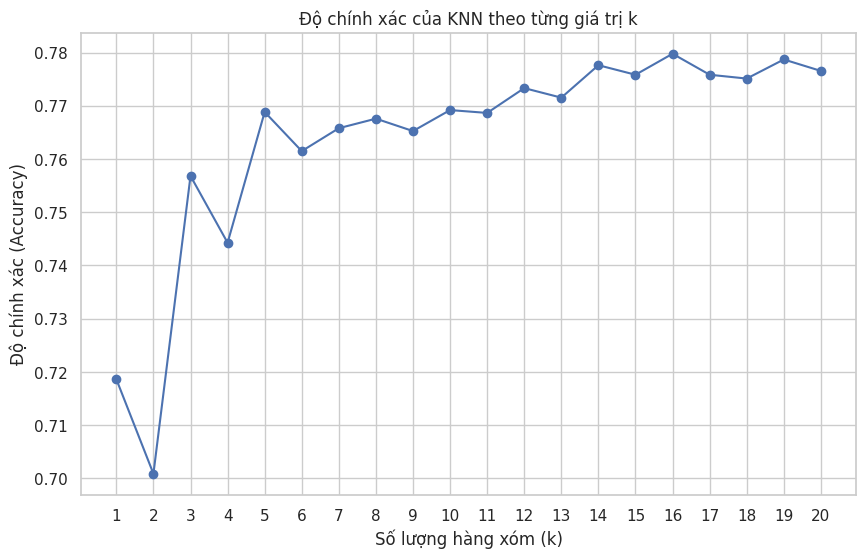

K tốt nhất là: 16 với độ chính xác: 0.78


In [ ]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

from sklearn.neighbors import KNeighborsClassifier
k_range = range(1, 21)  # Giá trị k từ 1 đến 20
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_k = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred_k)
    accuracies.append(acc)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o', linestyle='-', color='b')
plt.xticks(k_range)
plt.xlabel('Số lượng hàng xóm (k)')
plt.ylabel('Độ chính xác (Accuracy)')
plt.title('Độ chính xác của KNN theo từng giá trị k')
plt.grid(True)
plt.show()

# In k tốt nhất
best_k = k_range[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"K tốt nhất là: {best_k} với độ chính xác: {best_acc:.2f}")

In [ ]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

from sklearn.neighbors import KNeighborsClassifier
# define the model
classifier = KNeighborsClassifier(n_neighbors=16, weights='distance', algorithm='auto', p=2, metric='minkowski')

classifier.fit(X_train, y_train)
# Dự đoán
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Ma trận nhầm lẫn
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)

# Độ chính xác (Accuracy)
accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)

# In kết quả
print("Confusion Matrix - Training:")
print(cm_train)
print("\nConfusion Matrix - Test:")
print(cm_test)

print('\nAccuracy for training set: {}'.format(accuracy_for_train))
print('Accuracy for test set    : {}'.format(accuracy_for_test))

print('\nF1 Score for training set: {:.2f}'.format(f1_train))
print('F1 Score for test set    : {:.2f}'.format(f1_test))


Confusion Matrix - Training:
[[ 9275     0]
 [    0 13026]]

Confusion Matrix - Test:
[[1475  798]
 [ 449 2854]]

Accuracy for training set: 1.0
Accuracy for test set    : 0.78

F1 Score for training set: 1.00
F1 Score for test set    : 0.82


In [ ]:
#Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

# Tách dữ liệu
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình
classifier = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=2, random_state=42)
classifier.fit(X_train, y_train)

# Dự đoán
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Ma trận nhầm lẫn
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)

# Accuracy
accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)

# In kết quả
print("Confusion Matrix - Training:")
print(cm_train)
print("\nConfusion Matrix - Test:")
print(cm_test)

print('\nAccuracy for training set: {}'.format(accuracy_for_train))
print('Accuracy for test set    : {}'.format(accuracy_for_test))

print('\nF1 Score for training set: {:.2f}'.format(f1_train))
print('F1 Score for test set    : {:.2f}'.format(f1_test))


Confusion Matrix - Training:
[[ 7675  1493]
 [ 1020 12113]]

Confusion Matrix - Test:
[[1764  616]
 [ 439 2757]]

Accuracy for training set: 0.89
Accuracy for test set    : 0.81

F1 Score for training set: 0.91
F1 Score for test set    : 0.84


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

# Tách dữ liệu
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình Random Forest
classifier = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, n_estimators=10, random_state=42)
classifier.fit(X_train, y_train)

# Dự đoán
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Ma trận nhầm lẫn
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)

# Accuracy
accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)

# In kết quả
print("Confusion Matrix - Training:")
print(cm_train)
print("\nConfusion Matrix - Test:")
print(cm_test)

print('\nAccuracy for training set: {}'.format(accuracy_for_train))
print('Accuracy for test set    : {}'.format(accuracy_for_test))

print('\nF1 Score for training set: {:.2f}'.format(f1_train))
print('F1 Score for test set    : {:.2f}'.format(f1_test))


Confusion Matrix - Training:
[[ 7577  1591]
 [ 1023 12110]]

Confusion Matrix - Test:
[[1803  577]
 [ 380 2816]]

Accuracy for training set: 0.88
Accuracy for test set    : 0.83

F1 Score for training set: 0.90
F1 Score for test set    : 0.85


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Chuẩn bị dữ liệu
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình AdaBoost
classifier = AdaBoostClassifier(n_estimators=50, learning_rate=0.1, random_state=42)
classifier.fit(X_train, y_train)

# Tính accuracy sau mỗi vòng boosting
train_acc = []
test_acc = []

for y_pred_train in classifier.staged_predict(X_train):
    train_acc.append(accuracy_score(y_train, y_pred_train))

for y_pred_test in classifier.staged_predict(X_test):
    test_acc.append(accuracy_score(y_test, y_pred_test))

# In ra final accuracy
print(f"Final Train Accuracy: {train_acc[-1]:.4f}")
print(f"Final Test Accuracy:  {test_acc[-1]:.4f}")

# Ma trận nhầm lẫn
y_pred_train_final = classifier.predict(X_train)
y_pred_test_final = classifier.predict(X_test)

cm_train = confusion_matrix(y_train, y_pred_train_final)
cm_test = confusion_matrix(y_test, y_pred_test_final)

# F1 Score
f1_train = f1_score(y_train, y_pred_train_final)
f1_test = f1_score(y_test, y_pred_test_final)

# In ma trận nhầm lẫn & F1 score
print("\nConfusion Matrix - Training:")
print(cm_train)
print("\nConfusion Matrix - Test:")
print(cm_test)

print('\nF1 Score for training set: {:.2f}'.format(f1_train))
print('F1 Score for test set    : {:.2f}'.format(f1_test))



Final Train Accuracy: 0.8286
Final Test Accuracy:  0.8137

Confusion Matrix - Training:
[[ 6722  2446]
 [ 1376 11757]]

Confusion Matrix - Test:
[[1702  678]
 [ 361 2835]]

F1 Score for training set: 0.86
F1 Score for test set    : 0.85


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Chuẩn bị dữ liệu
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo mô hình Gradient Boosting
classifier = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=100,
    subsample=1.0,
    min_samples_split=2,
    max_depth=3,
    random_state=42
)
classifier.fit(X_train, y_train)

# Theo dõi quá trình accuracy theo từng vòng boosting
train_acc = []
test_acc = []

for y_train_pred in classifier.staged_predict(X_train):
    train_acc.append(accuracy_score(y_train, y_train_pred))

for y_test_pred in classifier.staged_predict(X_test):
    test_acc.append(accuracy_score(y_test, y_test_pred))

# Dự đoán cuối cùng
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# Ma trận nhầm lẫn
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

# F1 Score
f1_test = f1_score(y_test, y_pred_test)
f1_train = f1_score(y_train, y_pred_train)

# Accuracy
accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)

# In kết quả
print("\nConfusion Matrix - Training:")
print(cm_train)
print("\nConfusion Matrix - Test:")
print(cm_test)

print('\nAccuracy for training set for GradientBoostingClassifier = {}'.format(accuracy_for_train))
print('Accuracy for test set for GradientBoostingClassifier = {}'.format(accuracy_for_test))

print('\nF1 Score for training set: {:.2f}'.format(f1_train))
print('F1 Score for test set    : {:.2f}'.format(f1_test))




Confusion Matrix - Training:
[[ 7332  1836]
 [ 1410 11723]]

Confusion Matrix - Test:
[[1848  532]
 [ 372 2824]]

Accuracy for training set for GradientBoostingClassifier = 0.85
Accuracy for test set for GradientBoostingClassifier = 0.84

F1 Score for training set: 0.88
F1 Score for test set    : 0.86


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pickle
# Chuẩn bị dữ liệu
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Khởi tạo và huấn luyện mô hình XGBoost
bst = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.01, objective='binary:logistic')
bst.fit(X_train, y_train)
filename='XGboost_model.aio'
pickle.dump(bst,open(filename,'wb'))


# Dự đoán
y_pred_test = bst.predict(X_test)
y_pred_train = bst.predict(X_train)

# Accuracy
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

# Confusion Matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

# F1 Score
f1_train = f1_score(y_train, y_pred_train)
f1_test = f1_score(y_test, y_pred_test)

# In kết quả
print("🔹 Confusion Matrix - Training:")
print(cm_train)

print("\n🔹 Confusion Matrix - Test:")
print(cm_test)

print("\n✅ Accuracy:")
print("Train Accuracy: {:.2f}".format(acc_train))
print("Test Accuracy : {:.2f}".format(acc_test))

print("\n🎯 F1 Score:")
print("Train F1 Score: {:.2f}".format(f1_train))
print("Test F1 Score : {:.2f}".format(f1_test))

sample_input = np.array([[1., 5., 1., 2., 5., 5., 5., 1., 1., 1., 1., 5., 5., 1.]])
sample_proba = bst.predict_proba(sample_input)
print("🔍 Xác suất dự đoán cho input:", sample_proba)


🔹 Confusion Matrix - Training:
[[ 7620  1548]
 [  598 12535]]

🔹 Confusion Matrix - Test:
[[1757  623]
 [ 334 2862]]

✅ Accuracy:
Train Accuracy: 0.90
Test Accuracy : 0.83

🎯 F1 Score:
Train F1 Score: 0.92
Test F1 Score : 0.86
🔍 Xác suất dự đoán cho input: [[0.16036618 0.8396338 ]]


In [ ]:
# from sklearn.svm import SVC

# classifier = SVC(kernel='rbf', random_state=42)
# classifier.fit(X_train, y_train)

# # Predicting the Test set results
# y_pred = classifier.predict(X_test)

# from sklearn.metrics import confusion_matrix
# cm_test = confusion_matrix(y_pred, y_test)

# y_pred_train = classifier.predict(X_train)
# cm_train = confusion_matrix(y_pred_train, y_train)

# print()
# accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
# accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)
# print('Accuracy for training set for SVC = {}'.format(accuracy_for_train))
# print('Accuracy for test set for SVC = {}'.format(accuracy_for_test))

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from xgboost import XGBClassifier
# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
# import numpy as np

# # Chuẩn bị dữ liệu
# X = data.iloc[:, :-1].values
# y = data.iloc[:, -1].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Mô hình cơ sở
# dtc = DecisionTreeClassifier(random_state=42)
# rfc = RandomForestClassifier(random_state=42)
# knn = KNeighborsClassifier()

# gc = GradientBoostingClassifier(random_state=42)
# svc = SVC(kernel='rbf', random_state=42)
# ad = AdaBoostClassifier(random_state=42)

# # Danh sách các mô hình cơ sở
# clf = [('dtc', dtc), ('rfc', rfc), ('knn', knn), ('gc', gc), ('ad', ad), ('svc', svc)]

# # Mô hình Meta
# xg = XGBClassifier()

# # StackingClassifier
# classifier = StackingClassifier(estimators=clf, final_estimator=xg)
# classifier.fit(X_train, y_train)

# # Dự đoán
# y_pred_test = classifier.predict(X_test)
# y_pred_train = classifier.predict(X_train)

# # Accuracy
# accuracy_train = accuracy_score(y_train, y_pred_train)
# accuracy_test = accuracy_score(y_test, y_pred_test)

# # F1 Score
# f1_train = f1_score(y_train, y_pred_train)
# f1_test = f1_score(y_test, y_pred_test)

# # Confusion Matrix
# cm_train = confusion_matrix(y_train, y_pred_train)
# cm_test = confusion_matrix(y_test, y_pred_test)

# # In kết quả
# print("🔹 Confusion Matrix - Training:")
# print(cm_train)

# print("\n🔹 Confusion Matrix - Test:")
# print(cm_test)

# print("\n✅ Accuracy:")
# print("Train Accuracy: {:.2f}".format(accuracy_train))
# print("Test Accuracy : {:.2f}".format(accuracy_test))

# print("\n🎯 F1 Score:")
# print("Train F1 Score: {:.2f}".format(f1_train))
# print("Test F1 Score : {:.2f}".format(f1_test))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np

# Chuẩn hóa và chia dữ liệu
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, :-1].values)
y = data.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuyển sang Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Tạo DataLoader
batch_size = 256
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Định nghĩa MLP + He Initialization
class MLP(nn.Module):
    def __init__(self, input_size, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, num_classes)
        )

        # He init cho tất cả Linear layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def forward(self, x):
        return self.net(x)

# Model, loss, optimizer
model = MLP(X_train.shape[1])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_accuracies = []
test_accuracies = []
train_losses = []
# Train
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        # Train acc & loss
        outputs_train = model(X_train_tensor)
        _, preds_train = torch.max(outputs_train, 1)
        correct_train = (preds_train == y_train_tensor).sum().item()
        acc_train = correct_train / len(y_train_tensor)
        train_accuracies.append(acc_train)

        # Test acc & loss
        outputs_test = model(X_test_tensor)
        test_loss = criterion(outputs_test, y_test_tensor)
        _, preds_test = torch.max(outputs_test, 1)
        correct_test = (preds_test == y_test_tensor).sum().item()
        acc_test = correct_test / len(y_test_tensor)

        test_losses.append(test_loss.item())
        test_accuracies.append(acc_test)

    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Acc: {acc_train:.4f} - Test Acc: {acc_test:.4f} - "
          f"Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

# Test
model.eval()
with torch.no_grad():
    y_pred_test = torch.argmax(model(X_test_tensor), dim=1)
    y_pred_train = torch.argmax(model(X_train_tensor), dim=1)

# Confusion matrix
cm_test = confusion_matrix(y_test, y_pred_test.numpy())
cm_train = confusion_matrix(y_train, y_pred_train.numpy())

accuracy_for_train = np.round((cm_train[0][0] + cm_train[1][1]) / len(y_train), 2)
accuracy_for_test = np.round((cm_test[0][0] + cm_test[1][1]) / len(y_test), 2)

print('Final Train Accuracy:', accuracy_for_train)
print('Final Test Accuracy:', accuracy_for_test)


Epoch [1/50] - Train Acc: 0.8444 - Test Acc: 0.8397 - Train Loss: 0.4471 - Test Loss: 0.3733
Epoch [2/50] - Train Acc: 0.8496 - Test Acc: 0.8370 - Train Loss: 0.3881 - Test Loss: 0.3724
Epoch [3/50] - Train Acc: 0.8514 - Test Acc: 0.8361 - Train Loss: 0.3735 - Test Loss: 0.3677
Epoch [4/50] - Train Acc: 0.8509 - Test Acc: 0.8397 - Train Loss: 0.3666 - Test Loss: 0.3672
Epoch [5/50] - Train Acc: 0.8509 - Test Acc: 0.8368 - Train Loss: 0.3663 - Test Loss: 0.3664
Epoch [6/50] - Train Acc: 0.8527 - Test Acc: 0.8368 - Train Loss: 0.3664 - Test Loss: 0.3674
Epoch [7/50] - Train Acc: 0.8522 - Test Acc: 0.8361 - Train Loss: 0.3599 - Test Loss: 0.3659
Epoch [8/50] - Train Acc: 0.8525 - Test Acc: 0.8355 - Train Loss: 0.3605 - Test Loss: 0.3659
Epoch [9/50] - Train Acc: 0.8525 - Test Acc: 0.8359 - Train Loss: 0.3576 - Test Loss: 0.3686
Epoch [10/50] - Train Acc: 0.8520 - Test Acc: 0.8357 - Train Loss: 0.3569 - Test Loss: 0.3678
Epoch [11/50] - Train Acc: 0.8521 - Test Acc: 0.8372 - Train Loss: 0.

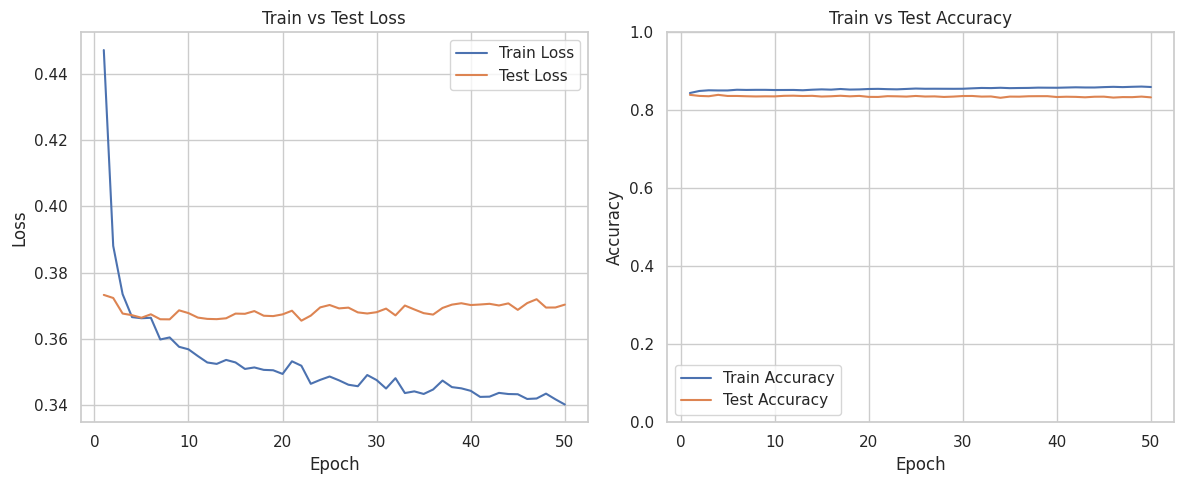

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# Vẽ Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.grid(True)

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.ylim(0, 1)  # <-- Đặt giới hạn trục y từ 0 đến 1
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(9168), np.int64(1): np.int64(13133)}


In [ ]:
torch.save(model.state_dict(), "mlp_model.pth")

In [ ]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

# Load lại mô hình kiến trúc
model = MLP(input_size=X_train.shape[1])
model.load_state_dict(torch.load("mlp_model.pth", map_location='cpu'))
model.eval()

# Dummy input (cần có kích thước giống input thật)
example_input = torch.rand(1, X_train.shape[1])

# Convert sang TorchScript
traced_model = torch.jit.trace(model, example_input)

# Optimize cho mobile
optimized_traced_model = optimize_for_mobile(traced_model)

# Save mô hình để dùng trong Android/iOS
optimized_traced_model._save_for_lite_interpreter("mlp_mobile.pt")


In [ ]:
# Sau khi fit scaler
print("Mean:", scaler.mean_)
print("Std:", scaler.scale_)

Mean: [ 1.44269469 25.81149335 18.85633318  1.00111203  3.14230369  7.65868216
  2.94461384  2.40083223  1.90533415 11.91397927  1.36704093  7.15729813
  3.13946981  1.51605266]
Std: [0.49670525 4.87780297 8.44688796 0.03332853 1.3807734  1.46457285
 1.36043757 1.12829972 0.79793238 7.23598135 0.48199781 3.70713413
 1.43745676 0.49974225]


In [ ]:
# Dữ liệu đầu vào (1 hàng, 13 đặc trưng)
raw_input = np.array([[1, 33.0, 19, 1, 5.0, 8.97, 2.0, 2, 3, 4, 1, 3.0, 1,2]])

In [ ]:
scaled_input = scaler.transform(raw_input)

In [ ]:
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

In [ ]:
import torch.nn.functional as F

raw_input = np.array([[1, 33.0, 19, 1, 5.0, 8.97, 2.0, 2, 3, 4, 1, 3.0, 1,2]])
scaled_input = scaler.transform(raw_input)
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

model.eval()
with torch.no_grad():
    output = model(input_tensor)

    # Tính xác suất
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()

    # Ép về numpy để dễ xử lý
    probs = probabilities.numpy()[0]

    print(f"Predicted class: {predicted_class}")
for i, p in enumerate(probs):
    print(f"Class {i}: {p*100:.2f}%")

Predicted class: 1
Class 0: 33.45%
Class 1: 66.55%


In [ ]:
model = MLP(input_size=14, num_classes=2)  # số features là 13

# Load trọng số đã lưu
model = torch.jit.load("mlp_mobile.pt")
model.eval()
# Input mẫu
raw_input = np.array([[1, 33.0, 23, 1, 5.0, 8.97, 2.0, 2, 3, 3, 1, 3.0, 1,2]])

# Chuẩn hóa bằng scaler đã fit
scaled_input = scaler.transform(raw_input)
print(scaled_input)
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

# Dự đoán
with torch.no_grad():
    output = model(input_tensor)
    probs = F.softmax(output, dim=1).numpy()[0]
    predicted_class = np.argmax(probs)
print(f"Predicted class: {predicted_class}")
for i, p in enumerate(probs):
    print(f"Class {i}: {p*100:.2f}%")

[[-0.89126237  1.47371813  0.49055544 -0.03336564  1.34540274  0.89535856
  -0.6943456  -0.35525333  1.37187797 -1.23189638 -0.76149917 -1.12143181
  -1.4883716   0.9683939 ]]
Predicted class: 1
Class 0: 32.96%
Class 1: 67.04%
